In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely import wkt
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,make_pc_map

In [2]:
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

In [3]:
#import pca from sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
#d18 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_18.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_eighteen = full_results[full_results['district'] == 18]
af_full = full_results[full_results['candidate'] == 'Amanda Farias']
winner_twenty_two = full_results_eighteen[full_results_eighteen['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_18 = full_results_eighteen['ed_name'].unique().tolist()
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
eds_18 = full_results_eighteen['ed_name'].unique().tolist()

In [5]:
bpp = pd.read_csv('../data/bronx_pres_primary.csv')
cvap = pd.read_csv('../data/cvap.csv')
africa = pd.read_csv('../data/africa.csv')

In [6]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [7]:
def rearrange(df,candidates):
    df = df[df['Unit Name'].isin(candidates)]
    df = df[['precinct','ed_name','Unit Name','Tally']]
    df.columns = ['precinct','ed_name','candidate','votes']
    df['ed_total'] = df.groupby('ed_name')['votes'].transform('sum')
    df['vote_share'] = round(df['votes'] / df['ed_total'] * 100,2)
    df['vote_share'] = pd.to_numeric(df['vote_share'], errors='coerce')
    return df

def make_ed_name(df):
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)

    return df

In [8]:
sr = pd.read_csv('../data/2017_bronx_18.csv')

In [9]:
candidates = ['William Russell Moore','Elvin Garcia','Amanda C. Farias','Michael Beltzer','Ruben Diaz Sr.']

In [10]:
sr = make_ed_name(sr)
sr = rearrange(sr,candidates)
sr['ed_name'] = sr['ed_name'].astype('Int64')

In [11]:
sr_with_cvap = sr.merge(cvap,left_on='ed_name',right_on='ElectDist')

In [12]:
af_basics = af_full[['ed_name','vote_share','total_vote_precinct']]

In [13]:
af_basics.columns = ['ed_name','af_vote','ed_total_2021']

In [14]:
sr_with_cvap = sr_with_cvap[sr_with_cvap['candidate'] == 'Amanda C. Farias']

In [15]:
sr_with_cvap.columns = ['precinct','ed_name','candidate','votes','ed_total_2017','af_17_vote','ElectDist','cvap']

In [16]:
two_year_cvap = sr_with_cvap[['ed_name','ed_total_2017','af_17_vote','cvap']].merge(af_basics,on='ed_name',how='left')

In [17]:
denom2017 = two_year_cvap['ed_total_2017']
two_year_cvap['share_2017'] = np.where(denom2017 == 0,
                                       np.nan,
                                       two_year_cvap['cvap'] / denom2017)

denom2021 = two_year_cvap['ed_total_2021']
two_year_cvap['share_2021'] = np.where(denom2021 == 0,
                                       np.nan,
                                       two_year_cvap['cvap'] / denom2021)

In [18]:
two_year_cvap['diff'] = two_year_cvap['share_2021'] - two_year_cvap['share_2017']

In [19]:
two_year_cvap[['af_17_vote','af_vote','share_2017','share_2021','diff']].corr()

,af_17_vote,af_vote,share_2017,share_2021,diff
af_17_vote,1.000000,-0.017298,0.338225,0.120887,-0.578939
af_vote,-0.017298,1.000000,-0.208684,-0.115031,0.217856
share_2017,0.338225,-0.208684,1.000000,0.766115,-0.894417
share_2021,0.120887,-0.115031,0.766115,1.000000,-0.397787
diff,-0.578939,0.217856,-0.894417,-0.397787,1.000000


In [20]:
two_year_cvap['increase'] = np.where(two_year_cvap['diff'] > 0, 'yes', 'no')
two_year_cvap.groupby('increase')[['af_vote','af_17_vote']].agg('mean')

,af_vote,af_17_vote
increase,,
no,26.450786,20.999541
yes,33.108100,17.742857


In [21]:
df = two_year_cvap

In [22]:
df  = df.merge(af_full[['ed_name','cvap21bapp','domin21p','prican21p','mhhi21']],on='ed_name',how='left')

In [23]:
df['log_mhhi21'] = np.log(df['mhhi21'])

In [24]:
with_pres = two_year_cvap.merge(bpp,on = 'ed_name',how='left')

In [75]:
with_pres.describe()

,ed_name,ed_total_2017,af_17_vote,cvap,af_vote,ed_total_2021,share_2017,share_2021,diff,vs16,vs20,vs24,first_diff,second_diff,third_diff,san16vs,san20vs
count,117.0,117.000000,116.000000,117.000000,114.000000,114.000000,116.000000,114.000000,114.000000,68.000000,68.000000,65.000000,68.000000,65.000000,65.000000,68.000000,68.000000
mean,86160.162393,81.444444,20.803017,881.528648,26.859568,122.745614,13.486183,8.503688,-4.501397,6.997059,12.979559,28.318308,5.982500,15.228308,21.299538,30.815441,20.832647
std,1243.36775,41.059554,9.001058,452.127100,7.953305,62.348409,11.640366,4.764363,6.846670,4.119303,4.451627,8.431085,2.690845,7.884990,7.209105,5.714558,6.358346
min,82023.0,0.000000,6.120000,21.544791,6.666667,2.000000,0.552431,1.486204,-59.657863,1.440000,6.040000,13.240000,0.630000,-0.840000,7.460000,18.180000,8.990000
25%,85030.0,56.000000,14.852500,580.840567,21.717677,83.000000,7.396873,4.822783,-5.632328,4.560000,9.792500,23.390000,3.905000,10.940000,16.760000,27.175000,16.312500
50%,87034.0,76.000000,20.225000,870.444432,26.937765,111.000000,10.938896,7.738977,-3.051004,6.775000,12.420000,27.060000,6.105000,15.050000,20.230000,30.060000,19.335000
75%,87067.0,100.000000,25.052500,1082.061221,30.993909,147.500000,16.357977,11.141775,-1.264084,8.665000,15.450000,32.020000,7.922500,19.080000,25.600000,34.477500,25.085000
max,87102.0,263.000000,75.000000,2411.896830,50.000000,296.000000,81.265137,21.749010,11.402044,31.030000,33.330000,60.140000,12.010000,43.110000,49.030000,45.980000,35.330000


In [41]:
full_results_eighteen.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Amanda Farias            3829.0
William Rivera           3733.0
Michael Beltzer          1854.0
Darlene Jackson          1564.0
Mohammed Mujumder        1406.0
Mirza M. Rashid           711.0
William Russell Moore     563.0
overvote                  143.0
Eliu A. Lara              130.0
Write-in                   68.0
Name: vote, dtype: float64

In [26]:
top_two = full_results_eighteen[full_results_eighteen['candidate'].isin(['Amanda Farias','William Rivera'])]
winners = top_two.loc[top_two.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [27]:
winners['candidate'].value_counts()

candidate
William Rivera    68
Amanda Farias     47
Name: count, dtype: int64

In [9]:
def assign_color(row):
    if row['candidate'] == 'William Rivera':
        return mpl.cm.Blues(row['norm'])
    else:
        return mpl.cm.Reds(row['norm'])

In [28]:
winners['color'] = winners.apply(assign_color, axis=1)

In [ ]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))
winners = winners.set_crs(epsg=2263, allow_override=True)
winners_3857 = winners.to_crs(epsg=3857)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

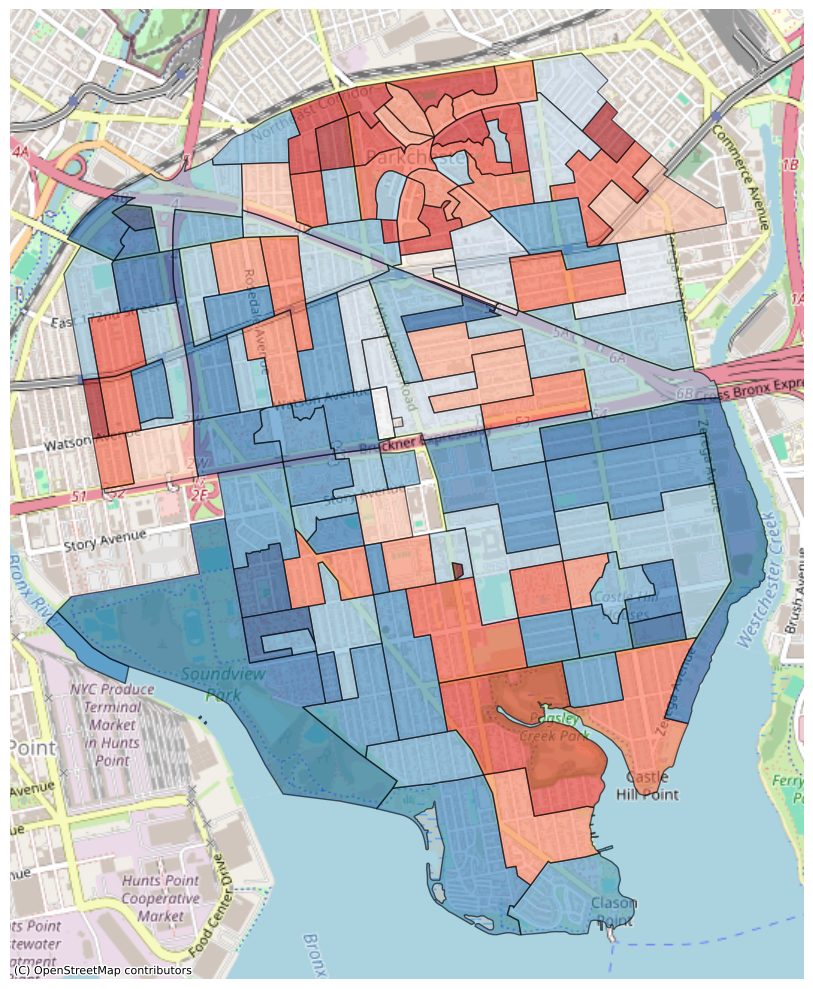

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
winners_3857.plot(
    color=winners_3857['color'],
    legend=True,
    ax=ax,
    alpha=0.6,
    edgecolor="k"
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [26]:
demo_occ = af_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [27]:
demo_occ = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry'].apply(wkt.loads))
demo_occ = demo_occ.set_crs(epsg=2263, allow_override=True)
demo_occ_3857 = demo_occ.to_crs(epsg=3857)

KeyError: 'geometry'

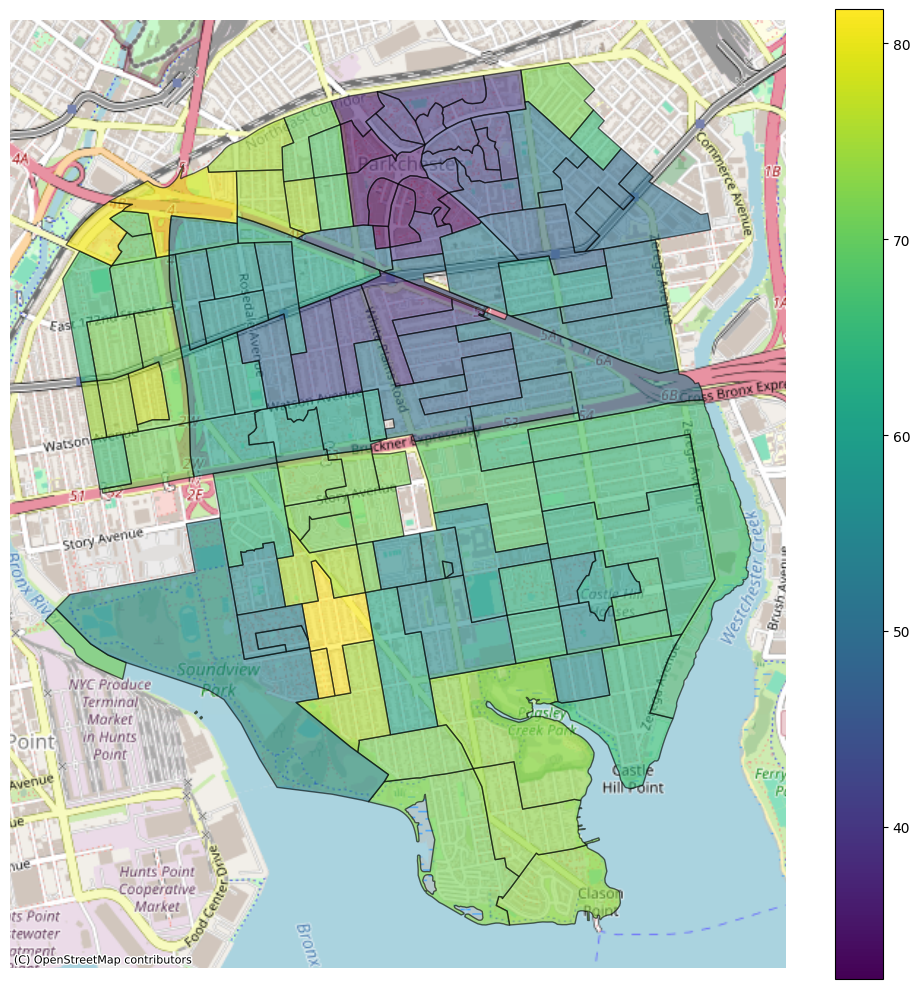

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
demo_occ_3857.plot(
    column="h21p",
    legend=True,
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [28]:
demo_occ = demo_occ.merge(with_pres,on='ed_name',how='left')
demo_occ = demo_occ.merge(africa,on='ElectDist',how='left')

In [32]:
africa.columns

Index(['ElectDist', 'african21p', 'afam21p', 'fb21wafp', 'fb21nafp'], dtype='object')

In [40]:
demo_occ[['vote_share','nhb21p','winda21p','pg20jrbp','pg20djtp','dpp20bs','adams213p','garcia213p',
          'drive_ratio', 'bus_ratio', 'train_ratio', 'african21p', 'afam21p', 'fb21wafp', 'fb21nafp',
          'domin21p','prican21p','diff','w2conp','w2tranp','w2edup','w2oadp']].corr().sort_values('vote_share',ascending=False)

,vote_share,nhb21p,winda21p,pg20jrbp,pg20djtp,dpp20bs,adams213p,garcia213p,drive_ratio,bus_ratio,...,afam21p,fb21wafp,fb21nafp,domin21p,prican21p,diff,w2conp,w2tranp,w2edup,w2oadp
vote_share,1.000000,0.123913,-0.042235,-0.000377,-0.007686,0.066774,-0.006059,0.139027,-0.036049,-0.040341,...,-0.050982,0.163053,-0.025104,-0.243451,-0.074573,0.217856,0.114708,0.071264,0.012322,0.009361
diff,0.217856,0.308508,0.080877,0.210304,-0.155886,0.191650,0.360138,-0.270604,-0.011930,0.208767,...,-0.011594,-0.107331,0.007832,0.068881,0.088511,1.000000,-0.010856,-0.099456,0.105364,-0.118064
fb21wafp,0.163053,-0.067881,-0.130953,-0.180371,0.183605,-0.208847,-0.128277,0.133949,-0.098123,-0.019008,...,0.331910,1.000000,0.105430,-0.145870,-0.122654,-0.107331,0.322445,0.072548,-0.141957,-0.108587
garcia213p,0.139027,-0.611650,-0.006990,-0.722395,0.711421,-0.388191,-0.874091,1.000000,0.240384,-0.281560,...,-0.220939,0.133949,0.026148,-0.119264,0.048105,-0.270604,0.092065,0.117091,0.043799,0.091644
nhb21p,0.123913,1.000000,0.083100,0.710177,-0.676896,0.447902,0.636416,-0.611650,-0.151855,0.528290,...,0.337209,-0.067881,-0.011026,-0.327514,-0.238378,0.308508,-0.255571,0.002574,0.219328,-0.210605
w2conp,0.114708,-0.255571,0.041963,-0.309402,0.269622,-0.257623,-0.158666,0.092065,-0.216168,-0.312542,...,-0.042478,0.322445,0.132343,0.078084,-0.184511,-0.010856,1.000000,-0.062668,-0.349603,-0.187260
w2tranp,0.071264,0.002574,0.140769,0.021220,-0.031263,0.179857,-0.263792,0.117091,-0.092203,-0.145343,...,-0.126102,0.072548,0.063535,-0.271563,-0.346452,-0.099456,-0.062668,1.000000,-0.045388,0.096302
dpp20bs,0.066774,0.447902,-0.020389,0.650193,-0.667758,1.000000,0.417409,-0.388191,-0.186835,0.290001,...,-0.193816,-0.208847,-0.118790,-0.182017,-0.164598,0.191650,-0.257623,0.179857,0.265194,0.002614
train_ratio,0.016389,-0.416393,0.058039,-0.204171,0.171039,-0.320367,-0.273138,0.295002,-0.027577,-0.373682,...,-0.060568,0.111892,-0.060918,-0.045681,0.089676,-0.273784,-0.050283,0.119439,-0.170813,0.312000
w2edup,0.012322,0.219328,0.180078,0.164330,-0.099341,0.265194,0.149936,0.043799,0.373238,0.091919,...,0.008408,-0.141957,-0.052888,-0.214196,0.305458,0.105364,-0.349603,-0.045388,1.000000,0.163692


In [31]:
cor_cols = ['vote_share','nhb21p','winda21p','mean_arrests','mean_noise','range_of_arrests','range_of_noise','cvap21bapp','mhhi21','venez21p',
                 'prican21p','colomb21p','domin21p','djt24p', 'wfp24p','nhw21p', 'nha21p', 'hh21op', 'drive_ratio', 'bus_ratio', 'train_ratio',
                 'rv21irp','rv21italp','pg20jrbp','pg20djtp','dpp20bs','adams213p','garcia213p','winda21p','vs20','diff'] + wp_cols
cor_cols = demo_occ.drop(columns=['ElectDist','Precinct','ed_name','candidate','matched_name','member','geometry_x','geometry_y','increase']).columns.tolist()
corr_matrix = demo_occ[cor_cols].corr()
corr_matrix.dropna(subset=['vote_share'], inplace=True)
corr_matrix.sort_values('vote_share', ascending=False,inplace=True)
corr_matrix[['vote_share','diff']].tail(25)

,vote_share,diff
djtpch,-0.149485,-0.243841
wf2cmgt,-0.150011,0.046411
wf2prod,-0.152419,-0.025670
wf2acfppd,-0.154509,0.003324
ldensity,-0.155963,-0.194062
min_noise,-0.159582,-0.000737
w2docp,-0.160195,0.027496
wm2util,-0.161070,-0.113290
summer_noise_complaints,-0.162014,-0.025251
first_diff,-0.162274,0.069999


In [34]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [51]:
target = demo_occ['vote_share']
mod1 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp','h21p','nhb21p']])).fit()
mod2 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp','h21p','nhb21p','mean_arrests']])).fit()
mod3 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp','h21p','nhb21p','mean_arrests','domin21p','w2cmp','w2emrp','w2admp','w2bgp','garcia213p']])).fit()

In [52]:
summary_col([mod1,mod2,mod3], stars=True)

,vote_share I,vote_share II,vote_share III
const,18.7356***,17.1215***,2.3808
,(6.3294),(6.1927),(10.7653)
cvap21bapp,0.2265**,0.2377**,0.1260
,(0.1089),(0.1061),(0.1507)
h21p,0.0225,0.0606,0.1006
,(0.0682),(0.0680),(0.0931)
nhb21p,0.0927,0.1376*,0.2495**
,(0.0821),(0.0817),(0.1148)
mean_arrests,,-0.6420***,-0.5320**
,,(0.2421),(0.2483)


In [41]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA

In [42]:
test_cols =  ['nhb21p','winda21p','pg20jrbp','pg20djtp','dpp20bs','adams213p','garcia213p',
          'drive_ratio', 'bus_ratio', 'train_ratio', 'african21p', 'afam21p', 'fb21wafp', 'fb21nafp',
          'domin21p','prican21p','diff','w2conp','w2tranp','w2edup','w2oadp']

In [44]:
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [45]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.67883067 0.37221575 0.69253076 0.66109221 0.74522574 0.73283011
 0.75935904 0.51594295 0.51770652 0.65969234 0.54170993 0.48029889
 0.51301997 0.3538748  0.37866818 0.50884866 0.78281355 0.58827162
 0.57407227 0.56286199 0.54469298]
Overall KMO: 0.620023638878869
Bartlett’s test χ²: 1517.356911849523 p-value: 1.2225543207791933e-196


In [46]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [47]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'fb21nafp' (KMO=0.354); new overall KMO before recalculation = 0.620
Dropping 'domin21p' (KMO=0.385); new overall KMO before recalculation = 0.641
Dropping 'winda21p' (KMO=0.347); new overall KMO before recalculation = 0.671
Dropping 'prican21p' (KMO=0.429); new overall KMO before recalculation = 0.676
Dropping 'w2tranp' (KMO=0.352); new overall KMO before recalculation = 0.708


In [48]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

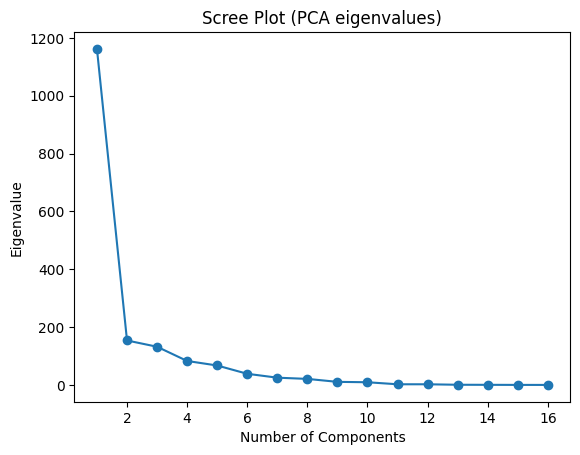

In [49]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [54]:
n_factors = 2
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [55]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [56]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                Factor1    Factor2
nhb21p       -5.975544   3.851341
pg20jrbp     -2.086428   1.240551
pg20djtp      1.890839  -1.034955
dpp20bs     -31.322898 -10.347749
adams213p    -3.806558   2.960653
garcia213p    2.316134  -1.960920
drive_ratio   2.197783  -0.489960
bus_ratio    -2.159805   0.638637
train_ratio   0.319378   0.110250
african21p    0.133805   0.109661
afam21p       0.244162   1.801304
fb21wafp      0.149874   0.011336
diff         -1.471627   0.286535
w2conp        3.025343  -0.818014
w2edup       -0.898147  -0.424140
w2oadp        0.057149  -0.265926


In [57]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4341
Date:                Thu, 23 Oct 2025   Prob (F-statistic):              0.649
Time:                        16:59:06   Log-Likelihood:                -397.20
No. Observations:                 114   AIC:                             800.4
Df Residuals:                     111   BIC:                             808.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8596      0.749     35.877      0.0

In [40]:
#PCA on cor_cols
pca = PCA(n_components=2)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(demo_occ[cor_cols])
pca.fit(df_scaled)
pca_df = pd.DataFrame(pca.transform(df_scaled), columns=['PC1','PC2'])

In [41]:
pca_df['vote_share'] = demo_occ['vote_share']
pca_df['ed_name'] = demo_occ['ed_name']

In [43]:
# pca loadings
pca_loadings = pd.DataFrame(pca.components_, columns=cor_cols, index=['PC1','PC2']).T

In [44]:
pca_loadings

,PC1,PC2
vote_share,0.014184,-0.146830
mean_arrests,0.057002,0.201304
mean_noise,-0.017590,-0.165969
range_of_arrests,0.102650,0.288559
range_of_noise,0.006597,-0.228477
cvap21bapp,0.206662,-0.178322
mhhi21,-0.118825,-0.070446
venez21p,0.022797,-0.132838
prican21p,-0.054959,0.226368
colomb21p,0.117656,-0.230163
